In [1]:
! pip install torch torchvision transformers pillow numpy scikit-learn

In [2]:
from PIL import Image, ImageEnhance
import torchvision.transforms as transforms

def preprocess_for_vit(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    # 색상 보정 (HSV 변환 후 명도(V) 조정)
    img_hsv = img.convert("HSV")
    enhancer = ImageEnhance.Brightness(img_hsv)
    img_hsv = enhancer.enhance(1.2)  # 밝기 조정

    # 데이터 증강 (Augmentation)
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 좌우 반전
        transforms.RandomRotation(10),  # 회전
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    img_tensor = transform(img_hsv)
    return img_tensor


In [10]:
import torch
import numpy as np
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# ViT 모델 로드
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# 전처리 함수 (Normalize 제거)
def preprocess_for_vit(img_path):
    img = Image.open(img_path).convert("RGB")
    img = img.resize((224, 224))

    # 색상 보정
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(1.2)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Normalize 제거
    ])
    
    return transform(img)

# 특징 벡터 추출 (정규화 문제 해결)
def extract_vit_features(img_path):
    img = preprocess_for_vit(img_path)
    
    # 이미지를 PIL/Numpy 형태로 변환하여 feature_extractor에 전달
    img_np = img.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
    inputs = feature_extractor(images=img_np, return_tensors="pt")

    with torch.no_grad():
        features = vit_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    
    return features

# 유사도 계산
def compute_vit_similarity(features1, features2):
    return {
        "cosine_similarity": cosine_similarity([features1], [features2])[0][0],
        "euclidean_distance": euclidean_distances([features1], [features2])[0][0],
        "manhattan_distance": manhattan_distances([features1], [features2])[0][0],
    }

# GAN 생성 이미지 & 추천 이미지 유사도 측정
def evaluate_similarities(gan_images, recommendation_images):
    # 특징 벡터 캐싱
    gan_features = {img: extract_vit_features(img) for img in gan_images}
    rec_features = {img: extract_vit_features(img) for img in recommendation_images}

    similarity_results = {}

    # 반복문을 이용한 유사도 계산
    for gan_img, gan_vec in gan_features.items():
        for rec_img, rec_vec in rec_features.items():
            pair = f"{gan_img} ↔ {rec_img}"
            similarity_results[pair] = compute_vit_similarity(gan_vec, rec_vec)

    return similarity_results

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/image_115.jpeg", "./ex_data/image_1.jpeg"]

results = evaluate_similarities(gan_img_paths, re_img_paths)

# 결과 출력
for pair, values in results.items():
    print(f"{pair} 유사도:")
    print(f"  코사인 유사도: {values['cosine_similarity']:.4f}")
    print(f"  유클리드 거리: {values['euclidean_distance']:.4f}")
    print(f"  맨해튼 거리: {values['manhattan_distance']:.4f}\n")


c:\Users\LG\elice\.venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


./ex_data/gan_1.png ↔ ./ex_data/image_115.jpeg 유사도:
  코사인 유사도: 0.9975
  유클리드 거리: 0.2498
  맨해튼 거리: 5.4324

./ex_data/gan_1.png ↔ ./ex_data/image_1.jpeg 유사도:
  코사인 유사도: 0.9990
  유클리드 거리: 0.1582
  맨해튼 거리: 3.5124

./ex_data/gan_2.png ↔ ./ex_data/image_115.jpeg 유사도:
  코사인 유사도: 0.9977
  유클리드 거리: 0.2398
  맨해튼 거리: 5.2195

./ex_data/gan_2.png ↔ ./ex_data/image_1.jpeg 유사도:
  코사인 유사도: 0.9988
  유클리드 거리: 0.1743
  맨해튼 거리: 3.8425



c:\Users\LG\elice\.venv\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


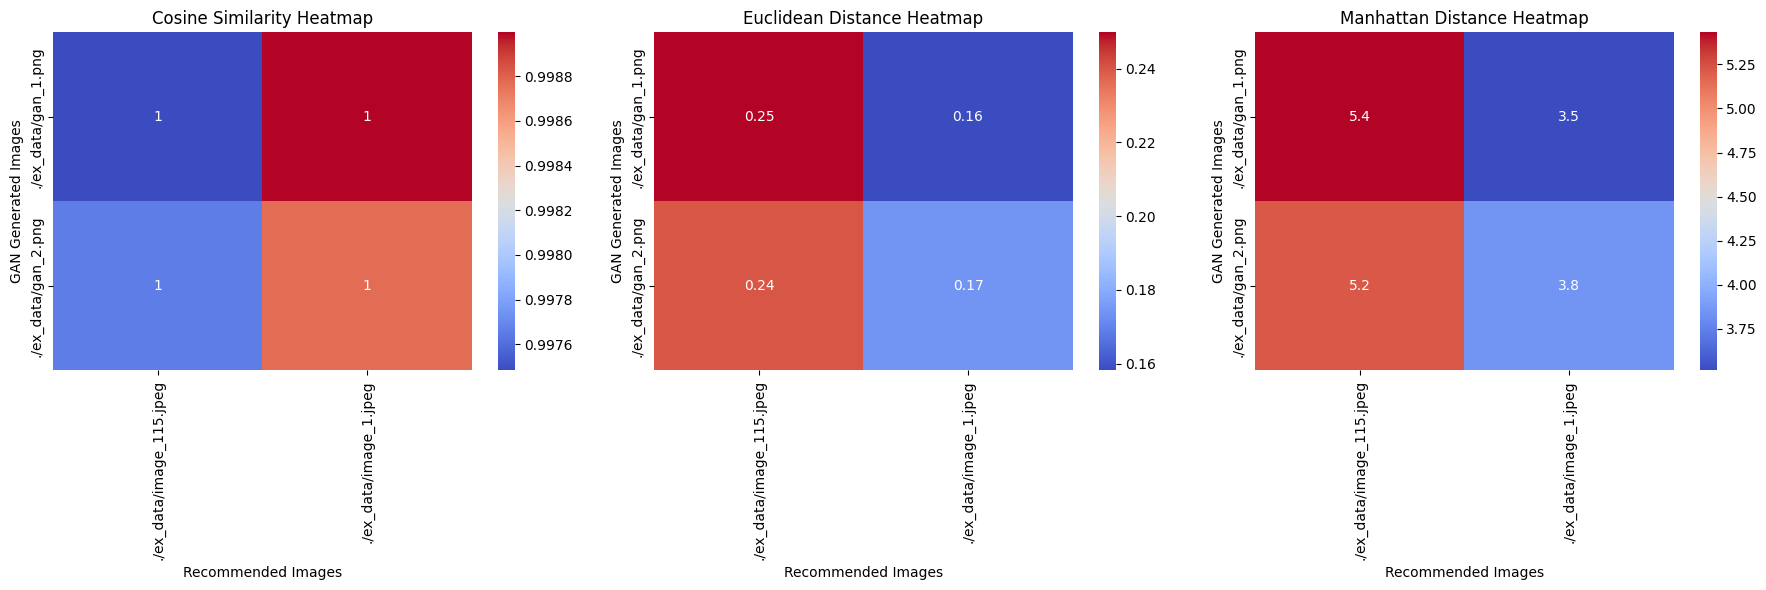

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# ViT 모델 로드
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# 이미지 전처리 (Normalize 제거)
def preprocess_for_vit(img_path):
    img = Image.open(img_path).convert("RGB").resize((224, 224))

    # 색상 보정
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(1.2)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Normalize 제거
    ])
    
    return transform(img)

# 특징 벡터 추출 (정규화 문제 해결)
def extract_vit_features(img_path):
    img = preprocess_for_vit(img_path)

    # (C, H, W) → (H, W, C) 변환 후 numpy 배열로 변환
    img_np = img.permute(1, 2, 0).numpy()  # (3, 224, 224) → (224, 224, 3)
    
    # feature_extractor가 직접 정규화 수행하도록 설정
    inputs = feature_extractor(images=img_np, return_tensors="pt")

    with torch.no_grad():
        features = vit_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    
    return features

# 유사도 계산 및 히트맵 시각화
def visualize_vit_similarity(gan_images, recommendation_images):
    # 특징 벡터 저장 (한 번만 계산)
    gan_features = {img: extract_vit_features(img) for img in gan_images}
    rec_features = {img: extract_vit_features(img) for img in recommendation_images}

    # 유사도 행렬 생성 (코사인, 유클리드, 맨해튼)
    cosine_matrix = np.zeros((len(gan_images), len(recommendation_images)))
    euclidean_matrix = np.zeros((len(gan_images), len(recommendation_images)))
    manhattan_matrix = np.zeros((len(gan_images), len(recommendation_images)))

    for i, gan_img in enumerate(gan_images):
        for j, rec_img in enumerate(recommendation_images):
            cos_sim = cosine_similarity([gan_features[gan_img]], [rec_features[rec_img]])[0][0]
            eucl_dist = euclidean_distances([gan_features[gan_img]], [rec_features[rec_img]])[0][0]
            manh_dist = manhattan_distances([gan_features[gan_img]], [rec_features[rec_img]])[0][0]

            cosine_matrix[i, j] = cos_sim
            euclidean_matrix[i, j] = eucl_dist
            manhattan_matrix[i, j] = manh_dist

    # 3개의 Heatmap 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # 코사인 유사도 Heatmap
    sns.heatmap(cosine_matrix, annot=True, cmap="coolwarm", xticklabels=recommendation_images, yticklabels=gan_images, ax=axes[0])
    axes[0].set_title("Cosine Similarity Heatmap")
    axes[0].set_xlabel("Recommended Images")
    axes[0].set_ylabel("GAN Generated Images")

    # 유클리드 거리 Heatmap
    sns.heatmap(euclidean_matrix, annot=True, cmap="coolwarm", xticklabels=recommendation_images, yticklabels=gan_images, ax=axes[1])
    axes[1].set_title("Euclidean Distance Heatmap")
    axes[1].set_xlabel("Recommended Images")
    axes[1].set_ylabel("GAN Generated Images")

    # 맨해튼 거리 Heatmap
    sns.heatmap(manhattan_matrix, annot=True, cmap="coolwarm", xticklabels=recommendation_images, yticklabels=gan_images, ax=axes[2])
    axes[2].set_title("Manhattan Distance Heatmap")
    axes[2].set_xlabel("Recommended Images")
    axes[2].set_ylabel("GAN Generated Images")

    plt.tight_layout()
    plt.show()

# 실행 예시
gan_img_paths = ["./ex_data/gan_1.png", "./ex_data/gan_2.png"]
re_img_paths = ["./ex_data/image_115.jpeg", "./ex_data/image_1.jpeg"]

visualize_vit_similarity(gan_img_paths, re_img_paths)


In [ ]:
# e데이터폴더셋으로 다시 유사도 측정
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import ViTFeatureExtractor, ViTModel
import torchvision.transforms as transforms
from PIL import Image, ImageEnhance
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances

# ViT 모델 로드
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

# 이미지 전처리 (Normalize 제거)
def preprocess_for_vit(img_path):
    img = Image.open(img_path).convert("RGB").resize((256, 256))

    # 색상 보정
    enhancer = ImageEnhance.Color(img)
    img = enhancer.enhance(1.2)

    transform = transforms.Compose([
        transforms.ToTensor(),  # Normalize 제거
    ])
    
    return transform(img)

# 특징 벡터 추출 (정규화 문제 해결)
def extract_vit_features(img_path, feature_cache):
    if img_path in feature_cache:
        return feature_cache[img_path]

    img = preprocess_for_vit(img_path)

    # (C, H, W) → (H, W, C) 변환 후 numpy 배열로 변환
    img_np = img.permute(1, 2, 0).numpy()  # (3, 224, 224) → (224, 224, 3)
    
    # feature_extractor가 직접 정규화 수행하도록 설정
    inputs = feature_extractor(images=img_np, return_tensors="pt")

    with torch.no_grad():
        features = vit_model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    # 캐시에 저장
    feature_cache[img_path] = features

    return features

# 유사도 계산 및 히트맵 시각화
def visualize_vit_similarity(gan_folder, recom_folder):
    # 폴더에서 모든 이미지 파일 가져오기
    gan_images = [os.path.join(gan_folder, img) for img in os.listdir(gan_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]
    recom_images = [os.path.join(recom_folder, img) for img in os.listdir(recom_folder) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # 특징 벡터 캐시 (중복 계산 방지)
    feature_cache = {}

    # 특징 벡터 저장
    gan_features = {img: extract_vit_features(img, feature_cache) for img in gan_images}
    rec_features = {img: extract_vit_features(img, feature_cache) for img in recom_images}

    # 유사도 행렬 생성 (코사인, 유클리드, 맨해튼)
    cosine_matrix = np.zeros((len(gan_images), len(recom_images)))
    euclidean_matrix = np.zeros((len(gan_images), len(recom_images)))
    manhattan_matrix = np.zeros((len(gan_images), len(recom_images)))

    for i, gan_img in enumerate(gan_images):
        for j, rec_img in enumerate(recom_images):
            cos_sim = cosine_similarity([gan_features[gan_img]], [rec_features[rec_img]])[0][0]
            eucl_dist = euclidean_distances([gan_features[gan_img]], [rec_features[rec_img]])[0][0]
            manh_dist = manhattan_distances([gan_features[gan_img]], [rec_features[rec_img]])[0][0]

            cosine_matrix[i, j] = cos_sim
            euclidean_matrix[i, j] = eucl_dist
            manhattan_matrix[i, j] = manh_dist

    # 3개의 Heatmap 시각화
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    gan_filenames = [os.path.basename(img) for img in gan_images]
    recom_filenames = [os.path.basename(img) for img in recom_images]

    # 코사인 유사도 Heatmap
    sns.heatmap(cosine_matrix, annot=True, cmap="coolwarm", xticklabels=recom_filenames, yticklabels=gan_filenames, ax=axes[0])
    axes[0].set_title("Cosine Similarity Heatmap")
    axes[0].set_xlabel("Recommended Images")
    axes[0].set_ylabel("GAN Generated Images")

    # 유클리드 거리 Heatmap
    sns.heatmap(euclidean_matrix, annot=True, cmap="coolwarm", xticklabels=recom_filenames, yticklabels=gan_filenames, ax=axes[1])
    axes[1].set_title("Euclidean Distance Heatmap")
    axes[1].set_xlabel("Recommended Images")
    axes[1].set_ylabel("GAN Generated Images")

    # 맨해튼 거리 Heatmap
    sns.heatmap(manhattan_matrix, annot=True, cmap="coolwarm", xticklabels=recom_filenames, yticklabels=gan_filenames, ax=axes[2])
    axes[2].set_title("Manhattan Distance Heatmap")
    axes[2].set_xlabel("Recommended Images")
    axes[2].set_ylabel("GAN Generated Images")

    plt.tight_layout()
    plt.show()

# 실행 예시 (폴더 경로 입력)
gan_folder_path = "C:/Users/LG/elice/data/gan_dataset"
recom_folder_path = "C:/Users/LG/elice/data/recommm_dataset"
visualize_vit_similarity(gan_folder_path, recom_folder_path)
